### 01 London Propery Listings.ipynb

### Steps:
- Step 0: Imports and Locations

In [59]:
#========================================================================
# Step 0: Imports

# Imports
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost
from xgboost import XGBClassifier

# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
#========================================================================

In [60]:
#========================================================================
# Step 1: Load Data
df=pd.read_csv('London Property Listings Dataset.csv')
df.columns = df.columns.str.replace(' ', '_')

print('--------------------')
print('## Information ##')
df.info()
print('--------------------')
print('')
#========================================================================

--------------------
## Information ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29537 entries, 0 to 29536
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           29537 non-null  float64
 1   Property_Type   29537 non-null  object 
 2   Bedrooms        29537 non-null  float64
 3   Bathrooms       29537 non-null  float64
 4   Size            29537 non-null  float64
 5   Postcode        29537 non-null  object 
 6   Area            29537 non-null  object 
 7   Price_Category  29537 non-null  object 
 8   Area_Avg_Price  29537 non-null  float64
dtypes: float64(5), object(4)
memory usage: 2.0+ MB
--------------------



In [61]:
#========================================================================
# Step 2: First 5 rows
print('--------------------')
print('## First 5 rows ##')
print(df.head(5))
print('--------------------')
#========================================================================

--------------------
## First 5 rows ##
      Price Property_Type  Bedrooms  Bathrooms   Size Postcode           Area  \
0  330000.0     Apartment       1.0        1.0  518.0      E14        Eastern   
1  340000.0          Flat       1.0        1.0    1.0      E14        Eastern   
2  340000.0     Apartment       1.0        1.0    2.0      E14        Eastern   
3  340000.0          Flat       1.0        1.0    1.0      E14        Eastern   
4  340000.0          Flat       1.0        1.0  388.0     SW20  South Western   

  Price_Category  Area_Avg_Price  
0            Low    1.001684e+06  
1            Low    1.001684e+06  
2            Low    1.001684e+06  
3            Low    1.001684e+06  
4            Low    1.516724e+06  
--------------------


In [62]:
#========================================================================
# Step 3: Delete Unnecessary Features

# Copy
df2=copy.deepcopy(df)

# Step 3a: Area_Avg_Price is simply the average of the price in the area
print('--------------------')
print('## Average Price for Each Area ##')
print(df[['Price','Area', 'Area_Avg_Price']].groupby(['Area', 'Area_Avg_Price']).mean())
print('--------------------')
print('')
df2=df2.drop(['Area_Avg_Price'], axis=1)
#========================================================================

--------------------
## Average Price for Each Area ##
                                              Price
Area                   Area_Avg_Price              
Bromley                4.187500e+05    4.187500e+05
Croydon                4.352941e+05    4.352941e+05
Eastern                1.001684e+06    8.419240e+05
Eastern Central        1.410220e+06    1.235202e+06
Enfield                5.015973e+05    5.015973e+05
Harrow                 5.106283e+05    5.106283e+05
Ilford                 5.856667e+05    5.856667e+05
Kingston               5.700000e+05    5.700000e+05
Kingston upon Thames   8.009967e+05    8.009967e+05
North Western          1.237283e+06    1.005454e+06
Northern               8.312952e+05    7.686065e+05
South Eastern          6.921048e+05    6.653810e+05
South Western          1.516724e+06    1.216610e+06
Sutton                 6.616667e+05    6.616667e+05
Twickenham             8.512587e+05    8.512587e+05
Western Central        1.625819e+06    1.423378e+06
Western a

In [63]:
#========================================================================
# Step 3b: Price_Category is simply banding the price into 4 categories
print('--------------------')
print('## Min and Max Price for each Price Category ##')
print(
df[['Price','Price_Category']]\
    .groupby(['Price_Category'])\
    .agg(['min', 'max', 'count']))
print('--------------------')
print('')
df2=df2.drop(['Price_Category'], axis=1)
#========================================================================

--------------------
## Min and Max Price for each Price Category ##
                    Price                  
                      min        max  count
Price_Category                             
High            1130000.0  2000000.0   4247
Low               65000.0   500000.0   7616
Luxury          2008000.0  5950000.0   2597
Medium           500250.0  1125000.0  15077
--------------------



In [64]:
#========================================================================
# Step 3c: Some areas have only a few examples
# Create a new feature to group these areas
print('--------------------')
print('## Count of Area ##')
area_summary=df2['Area'].value_counts().reset_index()
area_summary['AreaGroup']=np.where(area_summary['count']<100, 'Other',area_summary['Area'])
print(area_summary)
df2=pd.merge(df2, area_summary[['Area', 'AreaGroup']], left_on='Area', right_on='Area', how='left')
df2[['AreaGroup','Area']].groupby(['AreaGroup','Area']).size().reset_index()
df2=df2.drop(['Area'], axis=1)
print('--------------------')
print('')
#========================================================================

--------------------
## Count of Area ##
                      Area  count               AreaGroup
0                  Eastern  13075                 Eastern
1            South Western   4993           South Western
2   Western and Paddington   3265  Western and Paddington
3            South Eastern   2813           South Eastern
4            North Western   2376           North Western
5                 Northern   1686                Northern
6               Twickenham    507              Twickenham
7          Eastern Central    432         Eastern Central
8          Western Central    223         Western Central
9                  Enfield    101                 Enfield
10                  Harrow     23                   Other
11                 Croydon     17                   Other
12    Kingston upon Thames     15                   Other
13                 Bromley      4                   Other
14                  Ilford      3                   Other
15                  Sutton     

In [65]:
#========================================================================
# Step 3d: Postcode is too granular
print('--------------------')
print('## Most Commont Postcodes ##')
print(
df2[['Postcode']]\
    .groupby(['Postcode'])\
    .size()\
    .sort_values(ascending=False)\
    .head(10))
print('--------------------')
print('')
df2=df2.drop(['Postcode'], axis=1)
#========================================================================

--------------------
## Most Commont Postcodes ##
Postcode
E14     10899
SW11      729
W2        617
SW6       518
SE1       493
E16       368
SW8       350
NW8       347
NW9       320
E1        305
dtype: int64
--------------------



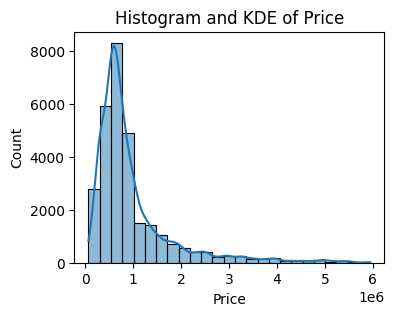

In [48]:
#========================================================================
# Step 4: Plot Response
plt.figure(figsize=(4,3))
sns.histplot(df2, x='Price', bins=25, kde=True)
plt.title('Histogram and KDE of Price', loc='center')
plt.show()
#========================================================================

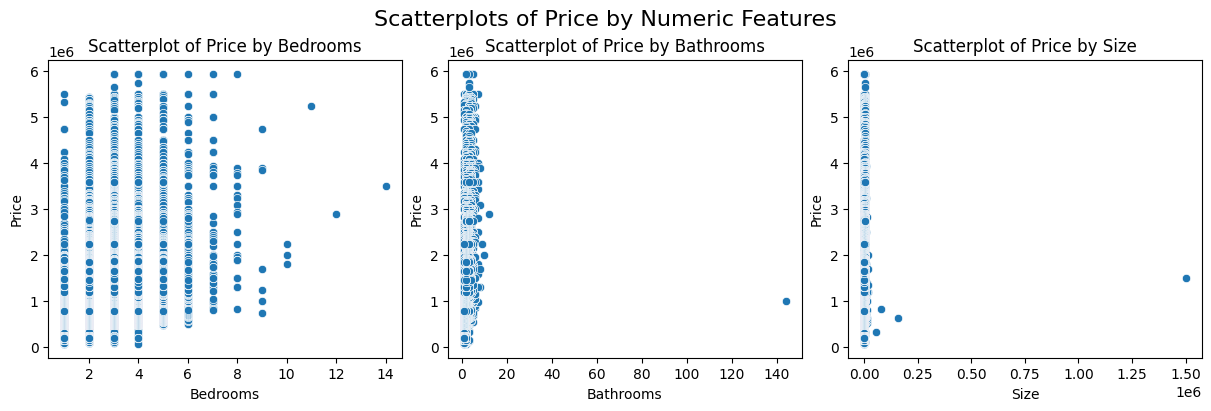

In [49]:
#========================================================================
# Step 5a: Plot Numeric Features

# Numeric Features
numeric_cols = df2.select_dtypes(include=[np.number]).columns.drop('Price')

# Scatterplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
for i, this_var in enumerate(numeric_cols):
    sns.scatterplot(data=df2, 
                    x=this_var, 
                    y='Price', 
                    ax=axes[i])
    axes[i].set_title(f'Scatterplot of Price by {this_var}', fontsize=12)
fig.suptitle('Scatterplots of Price by Numeric Features', fontsize=16)
plt.show()
#========================================================================

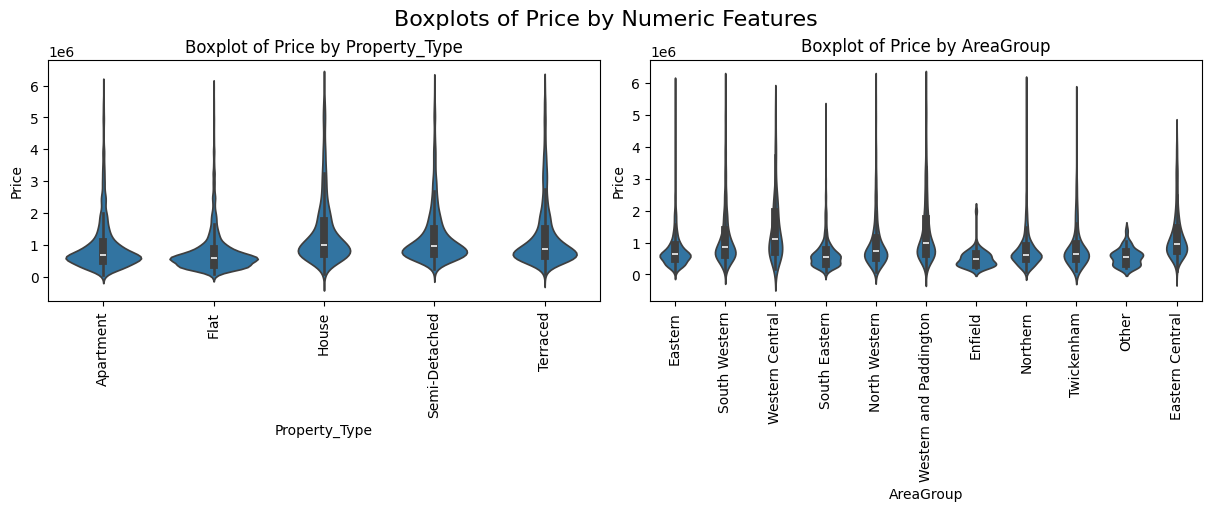

In [71]:
#========================================================================
# Step 5b: Plot Categorical Features

# Categorical Features
categorical_cols = df2.select_dtypes(exclude=[np.number]).columns

# Scatterplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
for i, this_var in enumerate(categorical_cols):
    sns.violinplot(data=df2, 
                    x=this_var, 
                    y='Price', 
                    ax=axes[i])
    axes[i].set_title(f'Boxplot of Price by {this_var}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=90) 
fig.suptitle('Boxplots of Price by Numeric Features', fontsize=16)
plt.show()
#========================================================================

In [72]:
#========================================================================
# Step 6: Delete Outliers

# Step 6a: 1 bedroom appartment, 144 bathrooms
print('--------------------')
print('## Outlier Bathrooms ##')
print(df2[df2['Bathrooms']>=20])
print('--------------------')
print('')
df2=df2[df2['Bathrooms']<20]
#========================================================================

--------------------
## Outlier Bathrooms ##
          Price Property_Type  Bedrooms  Bathrooms   Size AreaGroup
14886  999000.0     Apartment       1.0      144.0  535.0  Northern
--------------------

--------------------
## Outlier Size ##
           Price  Property_Type  Bedrooms  Bathrooms       Size      AreaGroup
3713    325000.0           Flat       1.0        1.0    53798.0        Eastern
11956   830000.0      Apartment       1.0        1.0    78797.0  South Western
18886  1500000.0       Terraced       3.0        1.0  1500000.0        Eastern
24857   640000.0  Semi-Detached       5.0        2.0   158295.0        Enfield
--------------------

--------------------
## Information ##
<class 'pandas.core.frame.DataFrame'>
Index: 29532 entries, 0 to 29536
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          29532 non-null  float64
 1   Property_Type  29532 non-null  object 
 2   Bedrooms       29

In [ ]:
#========================================================================
# Step 6b: 1, 3 and 5 bedroom appartments, sizes over 50,000 sq feet
print('--------------------')
print('## Outlier Size ##')
print(df2[df2['Size']>=50E3])
print('--------------------')
print('')
df2=df2[df2['Size']<50E3]
#========================================================================

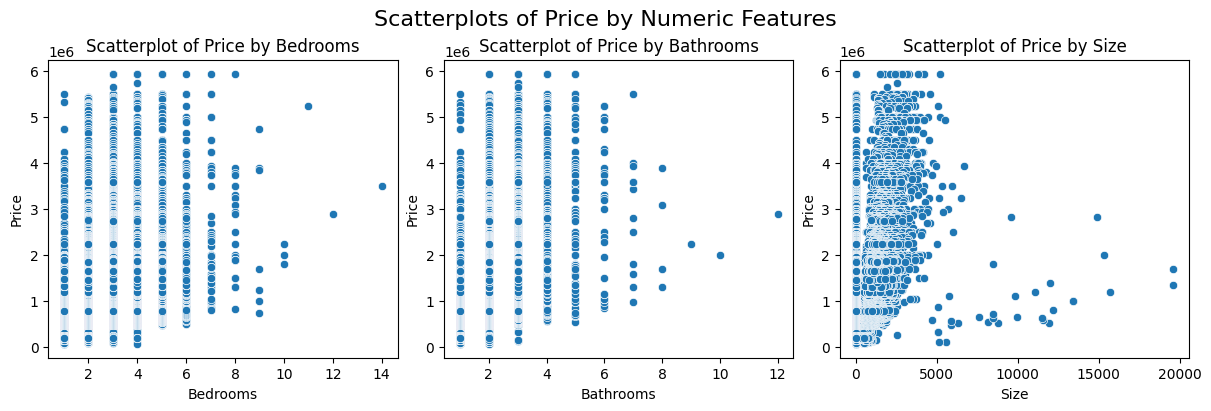

In [73]:
#========================================================================
# Step 7: Plot Numeric Features

# Numeric Features
numeric_cols = df2.select_dtypes(include=[np.number]).columns.drop('Price')

# Scatterplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
for i, this_var in enumerate(numeric_cols):
    sns.scatterplot(data=df2, 
                    x=this_var, 
                    y='Price', 
                    ax=axes[i])
    axes[i].set_title(f'Scatterplot of Price by {this_var}', fontsize=12)
fig.suptitle('Scatterplots of Price by Numeric Features', fontsize=16)
plt.show()
#========================================================================

In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29532 entries, 0 to 29536
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          29532 non-null  float64
 1   Property_Type  29532 non-null  object 
 2   Bedrooms       29532 non-null  float64
 3   Bathrooms      29532 non-null  float64
 4   Size           29532 non-null  float64
 5   AreaGroup      29532 non-null  object 
dtypes: float64(4), object(2)
memory usage: 1.6+ MB
